# Advanced Lane Finding Project
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera Calibration

In [36]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

def calibrate_camera():
    
    # number of squares in x axis
    nx = 9
    # number of squares in y axis
    ny = 6
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob("./camera_cal/calibration*.jpg")
    print("Reading images for calibration...")
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        print("Finding corners on ", fname, "...")
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            just_file_name = fname.split('/')[-1]
            print("Writing to corners_found...")
            cv2.imwrite(os.path.join("./camera_cal/corners_found/", just_file_name), img)
    
    # Get image size
    img_size = (img.shape[1],img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    # Save the camera calibration result for later process
    print("Saving the parameter to file: camera_cal/camera_cal.p")
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle_file = open("./camera_cal/camera_cal.p", "wb")
    pickle.dump(dist_pickle, pickle_file)
    pickle_file.close()
    
calibrate_camera()

Reading images for calibration...
Finding corners on  ./camera_cal/calibration5.jpg ...
Finding corners on  ./camera_cal/calibration4.jpg ...
Finding corners on  ./camera_cal/calibration6.jpg ...
Writing to corners_found...
Finding corners on  ./camera_cal/calibration7.jpg ...
Writing to corners_found...
Finding corners on  ./camera_cal/calibration3.jpg ...
Writing to corners_found...
Finding corners on  ./camera_cal/calibration2.jpg ...
Writing to corners_found...
Finding corners on  ./camera_cal/calibration1.jpg ...
Finding corners on  ./camera_cal/calibration20.jpg ...
Writing to corners_found...
Finding corners on  ./camera_cal/calibration19.jpg ...
Writing to corners_found...
Finding corners on  ./camera_cal/calibration18.jpg ...
Writing to corners_found...
Finding corners on  ./camera_cal/calibration15.jpg ...
Writing to corners_found...
Finding corners on  ./camera_cal/calibration14.jpg ...
Writing to corners_found...
Finding corners on  ./camera_cal/calibration16.jpg ...
Writin

A test to undistort a image

Reading the camera calibration parameters...
Reading the sample image...
Visulize the result...


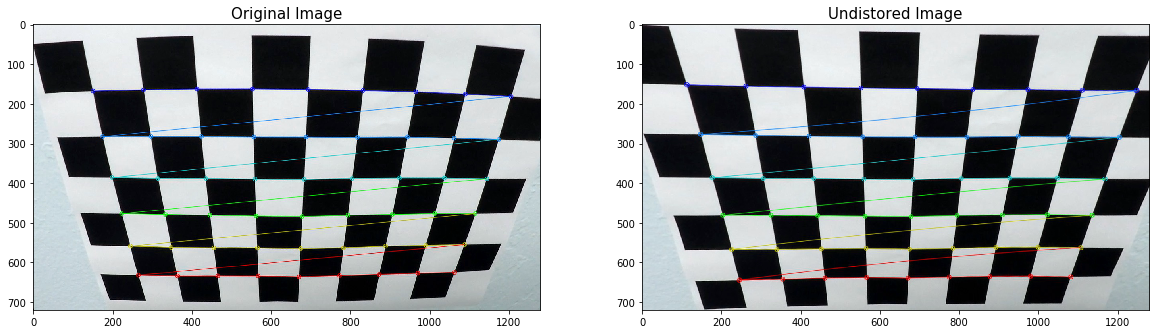

In [12]:
def test():
    """
    read the pickle file on disk and implement undistor on image
    show the oringal/undistort image
    """
    print("Reading the camera calibration parameters...")
    pickle_file = open("./camera_cal/camera_cal.p", "rb")
    dist_pickle = pickle.load(pickle_file)
    mtx = dist_pickle["mtx"]  
    dist = dist_pickle["dist"]
    pickle_file.close()

    print("Reading the sample image...")
    img = cv2.imread('./camera_cal/corners_found/calibration2.jpg')
    img_size = (img.shape[1],img.shape[0])
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    # Visualize undistortion
    print("Visulize the result...")
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
    ax1.imshow(img), ax1.set_title('Original Image', fontsize=15)
    ax2.imshow(dst), ax2.set_title('Undistored Image', fontsize=15)
    plt.show()

test()

## Helper functions that build up a pipeline

In [125]:
def get_camera_cal():
    """
    Read the picke file and return the mtx, dist to caller
    """
    pickle_file = open("./camera_cal/camera_cal.p", "rb")
    dist_pickle = pickle.load(pickle_file)
    mtx = dist_pickle["mtx"]  
    dist = dist_pickle["dist"]
    pickle_file.close()
    
    return mtx, dist

def undistort_image(img, mtx, dist):
    """
    Undistort an image, before calling this function, the camera calibration parameters
    should already be obtained by calling get_camera_cal()
    """
    return cv2.undistort(img, mtx, dist, None, mtx)

def color_gradient_thresh(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    """
    This is a combination of color and gradient thresholds to generate a binary image.
    In color space: it usees the s channel in HLS space;
    for gradient, it usees x direction gradient. 
    """
    np_img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(np_img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivateive in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivateive to accentuate lines
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # combine the two binary
    binary = sxbinary | s_binary

    # Stack each channel (for visual check the pixal sourse)
    # color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary,s_binary)) * 255
    return binary

def calculate_perspective_transform(image):
    """
    This functions gets an undistorted image, and get its bird-eye view.
    It also saves the transform parameters in to a pickle file.
    """
    img_size = (image.shape[1], image.shape[0])
    
    # copied from Udacity lecture and modified manully
    src = np.float32(
        [[(img_size[0] / 2) - 63, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 20), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

    # draw 4 lines
    print("Draw lines on image...")
    cv2.line(image, tuple(src[0]), tuple(src[1]), [255,0,0], 2)
    cv2.line(image, tuple(src[1]), tuple(src[2]), [255,0,0], 2)
    cv2.line(image, tuple(src[2]), tuple(src[3]), [255,0,0], 2)
    cv2.line(image, tuple(src[3]), tuple(src[0]), [255,0,0], 2)

    cv2.line(warped, tuple(dst[0]), tuple(dst[1]), [255,0,0], 2)
    cv2.line(warped, tuple(dst[1]), tuple(dst[2]), [255,0,0], 2)
    cv2.line(warped, tuple(dst[2]), tuple(dst[3]), [255,0,0], 2)
    cv2.line(warped, tuple(dst[3]), tuple(dst[0]), [255,0,0], 2)

    # write to pickle file
    print("Saving the perspective transform parameters to file: trans_pickle.p")
    trans_pickle = {}
    trans_pickle["M"] = M
    trans_pickle["Minv"] = Minv 
    pickle.dump(trans_pickle, open("trans_pickle.p", "wb"))

def get_perspective_transform_params():
    """
    Read the picke file and return the M, Minv to caller
    """
    pickle_file = open("trans_pickle.p", "rb")
    dist_pickle = pickle.load(pickle_file)
    M = dist_pickle["M"]  
    Minv = dist_pickle["Minv"]
    pickle_file.close()
    
    return M, Minv

def perspective_transform(image, M):
    """
    Do a perspective transform for an image, before calling this function, the transform parameters
    should already be obtained by calling get_perspective_transform_params()
    """
    img_size = (image.shape[1], image.shape[0])
    return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

def find_lane_sliding_window(warped_thresholed_img):
    """
    find lane in a warped and thresholed binary image
    input: warped_thresholed_img image
    output: left/right lane pixel poistion and a drawed search image
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped_thresholed_img[warped_thresholed_img.shape[0]//2:,:], axis=0)

    # plt.plot(histogram)
    # plt.show()

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped_thresholed_img, warped_thresholed_img, warped_thresholed_img))*255

    # Find the peak of the left and right havleve of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2) # 1280/2=640
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nWindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimu number of pixels found to recenter window
    min_pix = 50
    # Set height of windows - based on nWindows above adn image shape
    window_height = np.int(warped_thresholed_img.shape[0]//nWindows)
    # Identify the x and y positions of all nonzero(i.e. activated) pixels in the image
    nonzero = warped_thresholed_img.nonzero()
    nonzeroy = np.array(nonzero[0]) # y is row, x is col
    nonzerox = np.array(nonzero[1])
    # Current postions to be updated later for each window in n_window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nWindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_thresholed_img.shape[0] - (window+1)*window_height
        win_y_high = warped_thresholed_img.shape[0] - window*window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visulization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),
            (win_xleft_high, win_y_high), (0,255,0),2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),
            (win_xright_high, win_y_high), (0,255,0),2)
        
        # plt.imshow(out_img)
        # plt.show()

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]    # nonzero() return a tuple, get the list for tuple
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]  # nonzero() return a tuple, get the list for tuple

        # Append these indices to hte lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # # update the window center for next round window scan
        if len(good_left_inds) > min_pix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > min_pix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of list)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # print(len(nonzerox))
    return (leftx, lefty, rightx, righty, out_img)

def calculate_curvature(leftx, lefty, rightx, righty, ym_per_pix=30/720, xm_per_pix=3.7/700, Y_MAX=720, X_MAX=1280):
    '''
    Calcualtes the curvature of polynomial functions in meters
    '''
    # Transform pixel to meters
    leftx = leftx * xm_per_pix
    lefty = lefty * ym_per_pix
    rightx = rightx * xm_per_pix
    righty = righty * ym_per_pix

    # fit the polynomial
    left_fit_cr = np.polyfit(lefty, leftx, 2)
    right_fit_cr = np.polyfit(righty, rightx, 2)

    # Define y-value where we want radius of curvature
    # choose the maximum y-value
    y_eval = Y_MAX * ym_per_pix

    # Implement the caculation of R_curve
    # Caluate the radius R = (1+(2Ay+B)^2)^3/2 / (|2A|)
    radius_fun = lambda A, B, y: (1+(2*A*y+B)**2)**(3/2) / abs(2*A)

    left_curverad = radius_fun(left_fit_cr[0], left_fit_cr[1], y_eval)
    right_curverad = radius_fun(right_fit_cr[0], right_fit_cr[1], y_eval)

    return left_curverad, right_curverad

def calculate_offset(leftx, lefty, rightx, righty, ym_per_pix=30/720, xm_per_pix=3.7/700, Y_MAX=720, X_MAX=1280):
    '''
    calculate the the offest from lane center
    '''
    # HYPOTHESIS : the camera is mounted at the center of the car
    # the offset of the lane center from the center of the image is 
    # distance from the center of lane
    
    # Transform pixel to meters
    leftx = leftx * xm_per_pix
    lefty = lefty * ym_per_pix
    rightx = rightx * xm_per_pix
    righty = righty * ym_per_pix

    # fit the polynomial
    left_fit_cr = np.polyfit(lefty, leftx, 2)
    right_fit_cr = np.polyfit(righty, rightx, 2)

    # Define y-value where we want radius of curvature
    # choose the maximum y-value
    y_eval = Y_MAX * ym_per_pix

    left_point = np.poly1d(left_fit_cr)(y_eval)
    right_point = np.poly1d(right_fit_cr)(y_eval)

    lane_center = (left_point + right_point) / 2
    image_center = X_MAX * xm_per_pix / 2

    offset = lane_center - image_center

    return offset

def get_polynomial(leftx, lefty, rightx, righty, img_size):


    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    left_lane_fun = np.poly1d(left_fit)
    right_lane_fun = np.poly1d(right_fit)

    ploty = ploty = np.linspace(0, img_size[0]-1, img_size[0])
    left_fitx = left_lane_fun(ploty)
    right_fitx = right_lane_fun(ploty)

    return left_fitx, right_fitx, ploty

def draw_lane(undist, warped, Minv, leftx, lefty, rightx, righty):
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    color_warp[lefty, leftx] = [255, 0, 0]
    color_warp[righty, rightx] = [0 ,0 , 255]

    new_warp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))

    result = cv2.addWeighted(undist, 1, new_warp, 0.3, 0)

    return result

def draw_lane_fit(undist, warped, Minv, left_fitx, right_fitx, ploty):
    # Drawing
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix(Minv)
    new_warp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, new_warp, 0.3, 0)

    return result

def draw_lane_info(image, radius, offset, color=(0,255,255)):
    """
    project the fited lane information to the image
    use last 15 frame average data to avoid the number quick jump on screen.
    """
    if offset < 0:
        direction = "right"
    else:
        direction = "left"
    str_radius = "Radius of Curvature = {}m".format(int(radius))
    str_offset = "Vehicle is {0:.2f}m ".format(abs(offset)) + "{} of center".format(direction)
    cv2.putText(image, str_radius, (50,60), cv2.FONT_HERSHEY_SIMPLEX,2,color,2)
    cv2.putText(image, str_offset, (50,120), cv2.FONT_HERSHEY_SIMPLEX,2,color,2)

## Apply undistortion on a raw image captured by the same camera

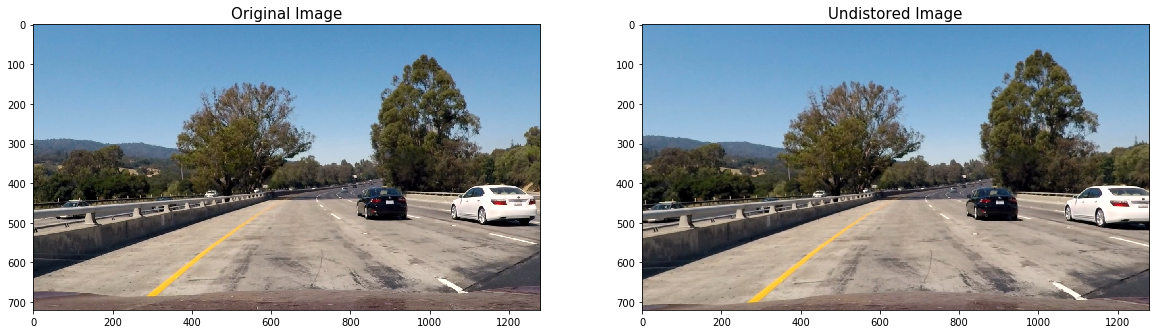

True

In [126]:
mtx, dist = get_camera_cal()
img = cv2.imread('test_images/test1.jpg')
# OpenCV loads in BGR by default
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = undistort_image(rgb_img, mtx, dist)

f, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(rgb_img), ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undistorted), ax2.set_title('Undistored Image', fontsize=15)
plt.show()

# save to output_images
bgr_undistorted = cv2.cvtColor(undistorted, cv2.COLOR_RGB2BGR)
cv2.imwrite(os.path.join("./output_images/test1_undistored.jpg", ), bgr_undistorted)


## Use color transforms and gradients to threshold an image

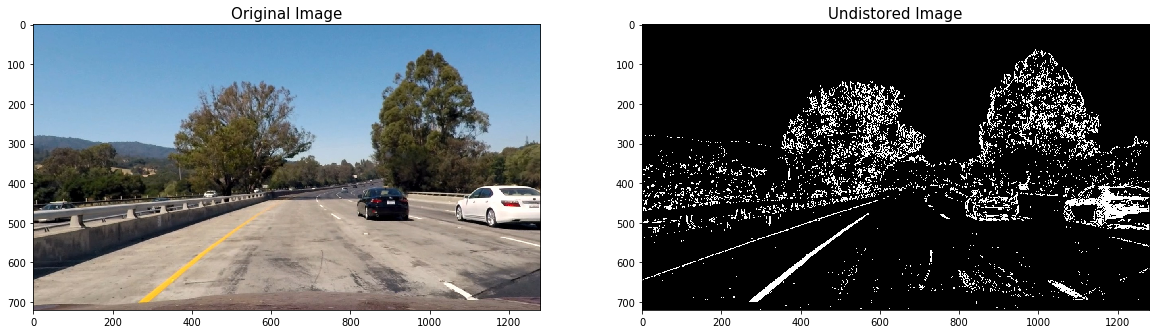

True

In [127]:
thresholded_img = color_gradient_thresh(undistorted)

# save to output_images
thresholded_img_visual = cv2.cvtColor(thresholded_img*255, cv2.COLOR_GRAY2RGB)

f, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(undistorted), ax1.set_title('Original Image', fontsize=15)
ax2.imshow(thresholded_img_visual), ax2.set_title('Undistored Image', fontsize=15)
plt.show()

# save to output_images
cv2.imwrite(os.path.join("./output_images/test1_thresholded.jpg", ), thresholded_img_visual)

## Perspective transform
We need to get a transform parameter M and the inverse transform parameter Minv. I did this once and save these two parameters to a pickle file just like how I get camera_cal.p. I had to pick 4 source points, which I did manually.

Draw lines on image for better visualisation...
Saving the perspective transform parameters to file: trans_pickle.p
Visulize the perspective trasnform result...


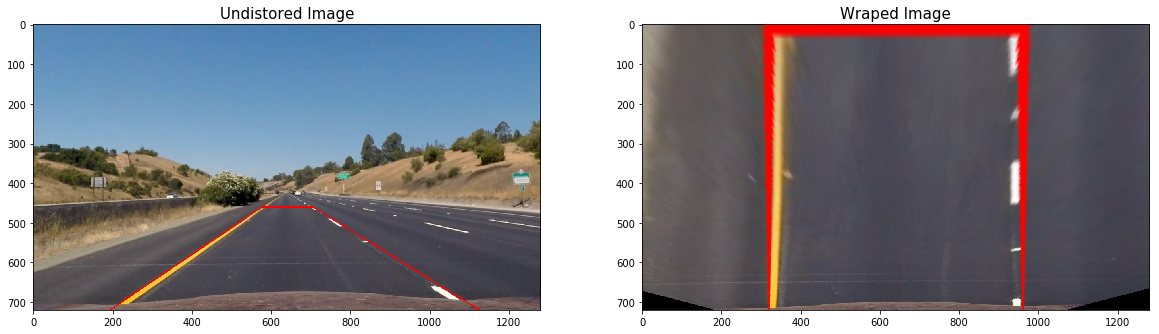

True

In [133]:
def calculate_perspective_transform(image):
    """
    This functions gets an undistorted image, and get its bird-eye view.
    It also saves the transform parameters in to a pickle file. Note this only works for specific
    test sets. In this example here, it works for test_images/straight_lines1.jpg
    """
    img_size = (image.shape[1], image.shape[0])
    
    # copied from Udacity lecture and modified manully
    src = np.float32(
        [[(img_size[0] / 2) - 63, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 20), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

    # draw 4 lines
    print("Draw lines on image for better visualisation...")
    cv2.line(image, tuple(src[0]), tuple(src[1]), [255,0,0], 2)
    cv2.line(image, tuple(src[1]), tuple(src[2]), [255,0,0], 2)
    cv2.line(image, tuple(src[2]), tuple(src[3]), [255,0,0], 2)
    cv2.line(image, tuple(src[3]), tuple(src[0]), [255,0,0], 2)

    cv2.line(warped, tuple(dst[0]), tuple(dst[1]), [255,0,0], 2)
    cv2.line(warped, tuple(dst[1]), tuple(dst[2]), [255,0,0], 2)
    cv2.line(warped, tuple(dst[2]), tuple(dst[3]), [255,0,0], 2)
    cv2.line(warped, tuple(dst[3]), tuple(dst[0]), [255,0,0], 2)

    # write to pickle file
    print("Saving the perspective transform parameters to file: trans_pickle.p")
    trans_pickle = {}
    trans_pickle["M"] = M
    trans_pickle["Minv"] = Minv 
    pickle_file = open("./trans_pickle.p", "wb")
    pickle.dump(trans_pickle, pickle_file)
    pickle_file.close()


straight_img = cv2.imread('test_images/straight_lines1.jpg')
# OpenCV loads in BGR by default
rgb_straight_img = cv2.cvtColor(straight_img, cv2.COLOR_BGR2RGB)
undistorted_rgb_straight_img = undistort_image(rgb_straight_img, mtx, dist)
calculate_perspective_transform(undistorted_rgb_straight_img)

M, Minv = get_perspective_transform_params()
warped = perspective_transform(undistorted_rgb_straight_img, M)

print("Visulize the perspective trasnform result...")
f, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(undistorted_rgb_straight_img), ax1.set_title('Undistored Image', fontsize=15)
ax2.imshow(warped), ax2.set_title('Wraped Image', fontsize=15)
plt.show()

# save to output_images
to_save = cv2.cvtColor(undistorted_rgb_straight_img, cv2.COLOR_RGB2BGR)
cv2.imwrite("./output_images/straight_lines1_trapezoid.jpg", to_save)
to_save = cv2.cvtColor(warped, cv2.COLOR_RGB2BGR)
cv2.imwrite("./output_images/straight_lines1_warped.jpg", to_save)

## Find lane pixels

True

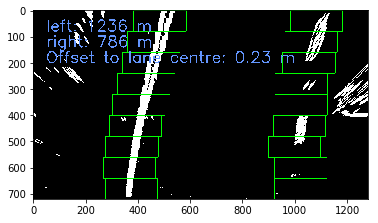

In [134]:
test_img = cv2.imread('test_images/test6.jpg')
# OpenCV loads in BGR by default
rgb_test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
undistorted_rgb_test_img = undistort_image(rgb_test_img, mtx, dist)
undistorted_thresholed_rgb = color_gradient_thresh(undistorted_rgb_test_img)

warped = perspective_transform(undistorted_thresholed_rgb, M)
img_size = (warped.shape[1], warped.shape[0])
leftx, lefty, rightx, righty, out_warped_img = find_lane_sliding_window(warped)

left_curverad, right_curverad = calculate_curvature(leftx, lefty, rightx, righty, ym_per_pix=30/720, xm_per_pix=3.7/700)
offset = calculate_offset(leftx, lefty, rightx, righty, ym_per_pix=30/720, xm_per_pix=3.7/700)

cur_left = "left: {} m".format(int(left_curverad))
cur_right = "right: {} m".format(int(right_curverad))
cur_pos = "Offset to lane centre: {:.2f} m".format(float(offset))

cv2.putText(out_warped_img,cur_left, (50,80), cv2.FONT_HERSHEY_SIMPLEX,2,(100,150,255),3)
cv2.putText(out_warped_img,cur_right, (50,140), cv2.FONT_HERSHEY_SIMPLEX,2,(100,150,255),3)
cv2.putText(out_warped_img,cur_pos, (50,200), cv2.FONT_HERSHEY_SIMPLEX,2,(100,150,255),3)
    
plt.imshow(out_warped_img)

# save to output_images
to_save = cv2.cvtColor(out_warped_img, cv2.COLOR_RGB2BGR)
cv2.imwrite("./output_images/test6_lane_detected.jpg", to_save)

## Draw lane area and display the curvature and offset text

True

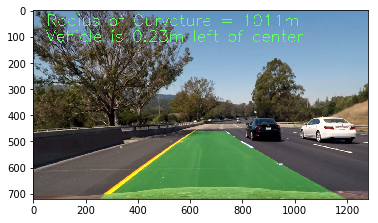

In [143]:
result = draw_lane(undistorted_rgb_test_img, warped, Minv, leftx, lefty, rightx, righty)
# get the polynomial line points
left_fitx, right_fitx, ploty = get_polynomial(leftx, lefty, rightx, righty, img_size)
result = draw_lane_fit(result, warped, Minv, left_fitx, right_fitx, ploty)
draw_lane_info(result, (left_curverad + right_curverad)/2, offset, color=(100,255,100))

plt.imshow(result)

# save to output_images
to_save = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
cv2.imwrite("./output_images/test6_lane_info_displayed.jpg", to_save)

## Create a pipeline class that constructs left and right lines

In [145]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 